# AutoPhaseNN
#### Pytorch version (under development)

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import torch
import torch.nn as nn

from tqdm.notebook import tqdm 
import numpy as np

from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.distributed import DistributedSampler
import matplotlib.pyplot as plt
import matplotlib

import params
from data_loader import *

### Plotting

In [2]:
plt.style.use('seaborn-v0_8-white')
#matplotlib.rc('xtick', labelsize=20) 
#matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 20
plt.viridis()
%matplotlib inline

<Figure size 640x480 with 0 Axes>

In [3]:
def plot6(data,titles):
    if(len(titles)<3):
        titles=["Plot1", "Plot2", "Plot3", "Plot4", "Plot5", "Plot6"]
    ind = data[0].shape[0]//2
    fig, axes = plt.subplots(1,6, figsize=(19,3), constrained_layout=True)
    for ix, ax in enumerate(axes):
        im=ax.imshow(data[ix][ind])
        plt.colorbar(im, ax=ax)
        ax.set_title(titles[ix])

### Load & Move model to appropriate device

In [4]:
from model import recon_model

model = recon_model()
model_path = params.MODEL_SAVE_PATH + 'best_model.pth'
model.load_state_dict(torch.load(model_path))

NGPUS = torch.cuda.device_count()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if NGPUS > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model) #Default all devices

model = model.to(device)

### Get filelist and load test data

In [5]:
dataname_list = os.path.join(params.data_path, '3D_upsamp.txt')
filelist = []
with open(dataname_list, 'r') as f:
    txtfile = f.readlines()
for i in range(len(txtfile)):
    tmp = str(txtfile[i]).split('/')[-1]
    tmp = tmp.split('\n')[0]

    filelist.append(tmp)
f.close()
print('number of available file:%d' % len(filelist))

number of available file:54028


In [6]:
# load test data
# give test data filelist
test_filelist = filelist[params.N_TRAIN:params.N_TRAIN+params.N_TEST]
print('number of test data:%d' % len(test_filelist))

# load test data 
test_dataset = Dataset(
    test_filelist, params.data_path, load_all=False, ratio=params.TRAIN_ratio, 
    dataset='test',scale_I=params.scale_I,shuffle=False)
test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False, num_workers=NGPUS*4)
# test_sampler = DistributedSampler(
#     test_dataset, num_replicas=1, rank=rank, shuffle=False)
# test_loader = DataLoader(
#     test_dataset, batch_size=16, sampler=test_sampler, shuffle=False, **kwargs)

number of test data:100


In [7]:
model.eval() #imp when have dropout etc
ft_results=[]
complex_results=[]
amp_preds = []
ph_preds  = []
supports = []

ft_test_array = []
amp_test_array = []
ph_test_array = []


for i, (ft_images,amps,phs) in tqdm(enumerate(test_loader)):
    ft_images = ft_images.to(device)
    y, complex_x, amp, ph, support = model(ft_images)
    #amp, ph, support = model(ft_images)
    for j in range(amp.shape[0]):
        #prediction
        ft_results.append([y[j].detach().to("cpu").numpy()])
        complex_results.append([complex_x[j].detach().to("cpu").numpy()])
        amp_preds.append(amp[j].detach().to("cpu").numpy())
        ph_preds.append(ph[j].detach().to("cpu").numpy())
        supports.append(support[j].detach().to("cpu").numpy())
        
        #ground truth
        ft_test_array.append([ft_images[j].detach().to("cpu").numpy()])
        amp_test_array.append([amps[j].detach().to("cpu").numpy()])
        ph_test_array.append([phs[j].detach().to("cpu").numpy()])
        

0it [00:00, ?it/s]

In [8]:
ft_results = np.array(ft_results).squeeze()
complex_results = np.array(complex_results).squeeze()
amp_preds = np.array(amp_preds).squeeze()
ph_preds = np.array(ph_preds).squeeze()
supports = np.array(supports).squeeze()

print(ft_results.shape, ft_results.dtype)

ft_test_array = np.array(ft_test_array).squeeze()
amp_test_array = np.array(amp_test_array).squeeze()
ph_test_array = np.array(ph_test_array).squeeze()

print(ft_test_array.shape, ft_test_array.dtype)

(100, 64, 64, 64) float32
(100, 64, 64, 64) float32


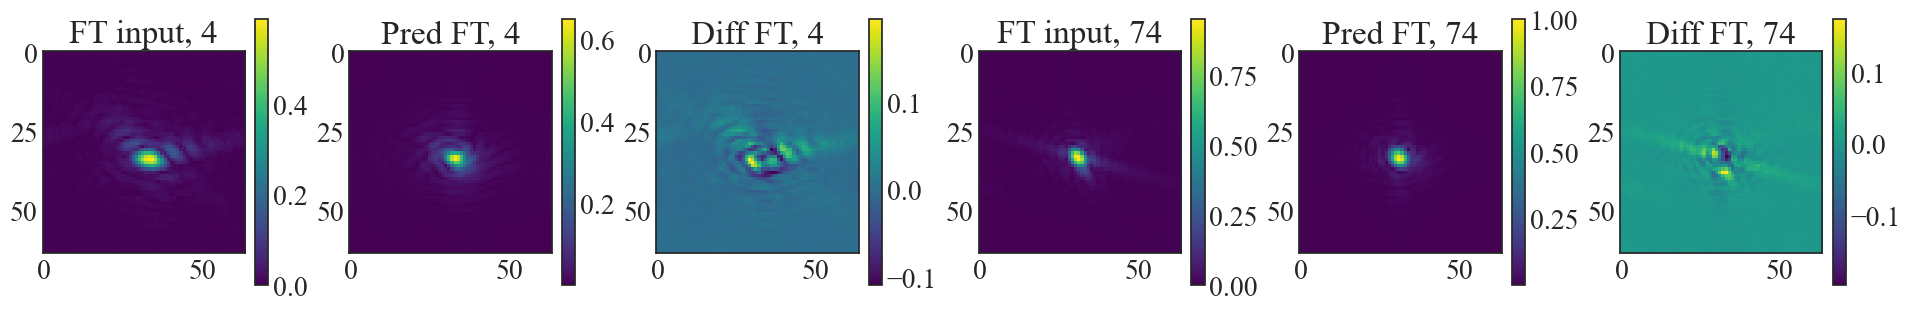

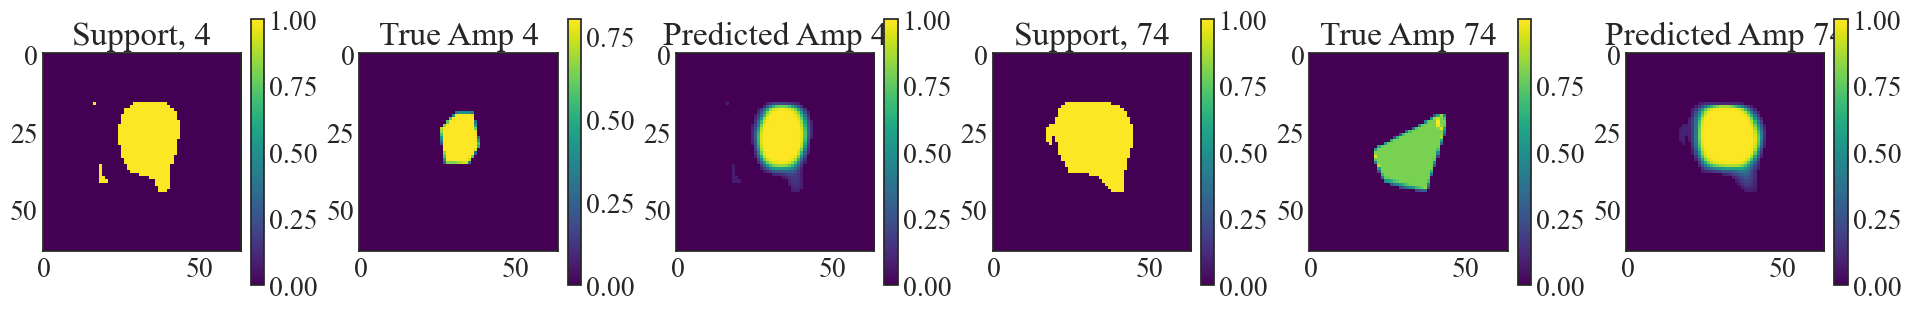

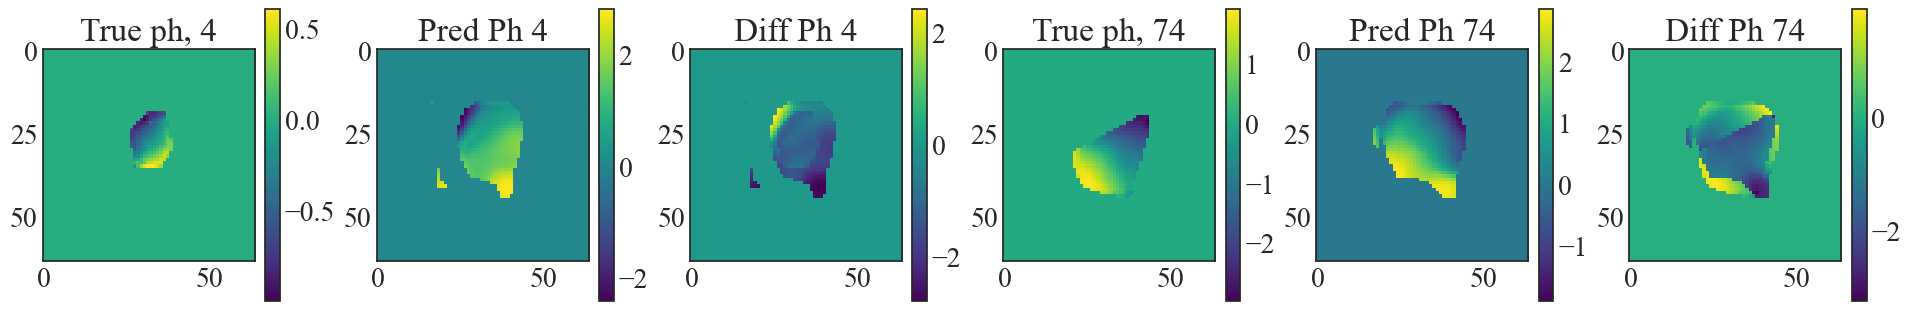

In [9]:
# Test images
to_plot = np.random.randint(100, size=2)
# to_plot = [20,50]

plots = {0:[], 1:[], 2:[]}
titles = {0:[], 1:[], 2:[]}
for i in to_plot:
    plots[0] += [ft_test_array[i],ft_results[i],ft_test_array[i]-ft_results[i]]
    titles[0] += [f"FT input, {i}", f"Pred FT, {i}", f"Diff FT, {i}"]
    
    plots[1] += [supports[i],amp_test_array[i],amp_preds[i]]
    titles[1] += [f"Support, {i}", f"True Amp {i}", f"Predicted Amp {i}"]
    
    tmp = ph_preds[i]*supports[i]
    plots[2] += [ph_test_array[i],tmp,ph_test_array[i]-tmp]
    titles[2] += [f"True ph, {i}", f"Pred Ph {i}", f"Diff Ph {i}"]

for j in range(3):
    plot6(plots[j], titles[j])